In [1]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest
from CP2LFI.scores import LambdaScore

from clover import Scores
from clover import LocartSplit

from copy import deepcopy

from tqdm import tqdm

In [2]:
err = {}
alpha = 0.05

# defining statistic of interest as a new score using the Scores class 
class LambdaScore(Scores):
    def fit(self, X, y):
        return self

    def compute(self, thetas, lambdas):
        return lambdas

    def predict(self, thetas, cutoff):
        pred = np.vstack((thetas - cutoff, thetas + cutoff)).T
        return pred

# First simulation

Let $\theta$ be the parameter of interest and $\lambda(\theta) = |F(1; \theta) - \hat{F}(1)|$ be the test statistic, where $F$ is the cummulative distribution of an $\text{exp}(\theta)$ evaluated at 1 and $\hat{F}$ the empirical cumulative distribution.

In [3]:
# o df_melted que retorna é só para printar as distribuicoes dos 
# lambdas com histplots e ver que elas mudam conforme theta

def generate_parameters(thetas, N, iters):
    values = pd.DataFrame()
    ## Parametros para arvore
    lambdas = []
    thetas_ = []
    ##
    for theta in thetas:
        diff = []
        theoretical = np.e**(-theta)
        for i in range(iters):
            exp = np.random.exponential(1/theta, N)
            empirical = (len([i for i in exp if i > 1])/len(exp))
            diff.append(abs(theoretical - empirical))
            lambdas.append(abs(theoretical - empirical))
            thetas_.append(theta)
        values[f"{theta}"] = diff
    df_melted = values.melt(var_name='theta')
    
    return lambdas, thetas_, df_melted

In [4]:
def eval_coverage(quantiles, thetas, iters = 10000, N = 10000, verbose = True):
    # theta = parametro
    # lambda = estatistica de teste
    # Lambda: |P_teorica(exp > 1) - P_empirica(exp > 1)|
    j = 0
    err = 0
    err_each = np.zeros(len(thetas))
    # computando erro padrao tambem
    for theta in thetas:
        theoretical = np.e**(-theta)
        lambdas_ = []
        for i in range(iters):
            distr = np.random.exponential(1/theta, N)
            empirical = len([i for i in distr if i > 1])/len(distr)
            diff = abs(theoretical - empirical)
            lambdas_.append(diff)
        alpha = len([i for i in lambdas_ if i >= quantiles[j]])/len(lambdas_)
        if verbose:
            print(f"alpha for theta={theta} : {alpha} --- quantile: {quantiles[j]}")
        err += abs(alpha - 0.05)
        err_each[j] = (alpha - 0.05)**2
        j += 1
    standard_error = np.std(err_each)
    if verbose:
        print(f"mean absolute error: {err/j}")
        print(f"standard error: {standard_error/np.sqrt(j)}")
    return [err/j, standard_error/np.sqrt(j)]

In [5]:
# isso foi usado em um experimento
def params_with_random_thetas(thetas, N):
    values = pd.DataFrame()
    chosen_thetas = np.random.choice(thetas, N)
    lambdas = []
    thetas_ = []
    ##
    for theta in chosen_thetas:
        theoretical = np.e**(-theta)
        exp = np.random.exponential(1/theta, 10000)
        empirical = len([i for i in exp if i > 1])/len(exp)
        lambdas.append(abs(theoretical - empirical))
        thetas_.append(theta)
    values = pd.DataFrame({"theta": [str(e) for e in thetas_],
                           "value": lambdas})
        
    return lambdas, thetas_, values

In [150]:
thetas = np.arange(0.5, 7, 0.5)

In [151]:
thetas

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5])

In [11]:
# Fica a vontade pra mudar isso aqui se quiser brincar
thetas = np.arange(0.5, 7, 0.5)
N = 10000
iters = 10000

np.random.seed(1250)
lambdas, thetas_, df_melted = generate_parameters(thetas, N, iters)

*df_melted* is the dataset with simulated $\lambda$ values for each value of $\theta$:

In [7]:
df_melted.head(10)

,theta,value
0,0.5,0.000369
1,0.5,0.003531
2,0.5,0.008069
3,0.5,0.003431
4,0.5,0.004531
5,0.5,0.004569
6,0.5,0.000669
7,0.5,0.009131
8,0.5,0.002969
9,0.5,0.005231


Implementing naive quantile estimation and prediction for any theta grid:

In [6]:
def train_naive_quantile(df_melted, thetas, alpha):
    quantiles = {}
    for theta in thetas:
        quantiles[theta] = np.quantile(list(df_melted[df_melted["theta"] == str(theta)].value), 1 - alpha)
    return quantiles

def predict_naive_quantile(theta_grid, quantiles_dict):
    thetas_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for theta in theta_grid:
        idx = thetas_values[int(np.argmin(np.abs(theta - thetas_values)))]
        quantiles_list.append(quantiles_dict[idx])
    return quantiles_list

We want to obtain, for each $\theta$ a cutoff $C_{\theta}$ to build:
$$R(\mathcal{D}) = \{\theta \in \Theta: \lambda(\theta, \mathcal{D}) \geq C_{\theta} \} ,$$
such that:
$$\mathbb{P}_{\mathcal{D}|\theta}(\theta \in R(\mathcal{D})) \geq 1 - \alpha \quad \forall \theta \in \Theta.$$

## First comparisson:

### Naive estimation

In [9]:
# isso aqui eh o que eu to chamando de naive. Basicamente pega o
# parametro e tira o quantil dele. usei o df_melted pq era mais facil
# por algum motivo que nao consigo lembrar de cabeça agora
# naive = [
#     np.quantile(list(df_melted[df_melted["theta"] == str(theta)].value), 0.95)
#    for theta in thetas
# ]

naive_quantiles = train_naive_quantile(df_melted, thetas = thetas, alpha = alpha)
naive = predict_naive_quantile(thetas, naive_quantiles)

In [10]:
err["err_naive"] = eval_coverage(naive, thetas)

alpha for theta=0.5 : 0.055 --- quantile: 0.009530659712633449
alpha for theta=1.0 : 0.0488 --- quantile: 0.009479441171442338
alpha for theta=1.5 : 0.0497 --- quantile: 0.008230160148429838
alpha for theta=2.0 : 0.0532 --- quantile: 0.0066352832366126935
alpha for theta=2.5 : 0.0576 --- quantile: 0.005284998623898807
alpha for theta=3.0 : 0.0517 --- quantile: 0.004312931632136051
alpha for theta=3.5 : 0.0536 --- quantile: 0.003302616577681494
alpha for theta=4.0 : 0.047 --- quantile: 0.0026843611112658157
alpha for theta=4.5 : 0.0532 --- quantile: 0.002008996538242309
alpha for theta=5.0 : 0.0512 --- quantile: 0.0016379469990854684
alpha for theta=5.5 : 0.0596 --- quantile: 0.0012132285615359317
alpha for theta=6.0 : 0.059 --- quantile: 0.0009787521766663593
alpha for theta=6.5 : 0.0741 --- quantile: 0.000703439192977573
mean absolute error: 0.00559230769230769
standard error: 0.0016826107334411324


### Pinball oriented Regression Tree
Fitting a regression tree that uses the pinball loss for partitioning the data:

In [11]:
# se colocar o boosting com 1 iteracao, ele vira uma arvore
# e o quantile loss eh o pinball. ref: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html
model = GradientBoostingRegressor(
    loss = "quantile", alpha = .95, min_samples_leaf = 100, n_estimators = 1, max_depth = None
)

model_thetas = np.array(thetas_).reshape(-1, 1)
model_lambdas = np.array(lambdas).reshape(-1, 1)
model.fit(model_thetas, model_lambdas)

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.95, loss='quantile', max_depth=None,
                          min_samples_leaf=100, n_estimators=1)

testing first a locart way of obtaining the cutoffs (pinball-LOCART):

In [12]:
model.apply(thetas.reshape(-1, 1))

array([[ 3.],
       [ 4.],
       [ 5.],
       [ 7.],
       [ 9.],
       [11.],
       [13.],
       [15.],
       [16.],
       [16.],
       [16.],
       [16.],
       [16.]])

Obtaining quantiles in the LOCART manner:

In [13]:
leaves = np.unique(model.apply(thetas.reshape(-1, 1)))
quantiles = {}
for leaf in leaves:
    indices = model.apply(model_thetas)
    selected_lambdas = model_lambdas[indices == leaf]
    n = selected_lambdas.shape[0]
    quantiles[leaf]  = np.quantile(selected_lambdas, q=np.ceil((n + 1) * (1 - 0.05)) / n)
idxs = model.apply(thetas.reshape(-1, 1))
list_gb_quantiles = [quantiles[idx] for idx in idxs.reshape(-1)]

Obtaining errors for these quantiles:

In [14]:
err["err_pinball_locart"] = eval_coverage(list_gb_quantiles, thetas)

alpha for theta=0.5 : 0.0505 --- quantile: 0.009530659712633449
alpha for theta=1.0 : 0.0503 --- quantile: 0.009479441171442338
alpha for theta=1.5 : 0.0479 --- quantile: 0.008230160148429838
alpha for theta=2.0 : 0.0557 --- quantile: 0.0066352832366126935
alpha for theta=2.5 : 0.0564 --- quantile: 0.005284998623898807
alpha for theta=3.0 : 0.0476 --- quantile: 0.004312931632136051
alpha for theta=3.5 : 0.054 --- quantile: 0.003302616577681494
alpha for theta=4.0 : 0.0482 --- quantile: 0.0026843611112658157
alpha for theta=4.5 : 0.1655 --- quantile: 0.0014910034617576905
alpha for theta=5.0 : 0.0663 --- quantile: 0.0014910034617576905
alpha for theta=5.5 : 0.0168 --- quantile: 0.0014910034617576905
alpha for theta=6.0 : 0.0033 --- quantile: 0.0014910034617576905
alpha for theta=6.5 : 0.0002 --- quantile: 0.0014910034617576905
mean absolute error: 0.0219
standard error: 0.008850293345855397


testing now cutoffs obtained from direct predictions of the model:

In [15]:
model = HistGradientBoostingRegressor(
    loss = "quantile", quantile = .95, min_samples_leaf = 100, max_iter=1
)

model_thetas = np.array(thetas_).reshape(-1, 1)
model_lambdas = np.array(lambdas).reshape(-1, 1)
model.fit(model_thetas, model_lambdas)

quantiles = model.predict(thetas.reshape(-1, 1))
quantiles

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.00650547, 0.00650364, 0.00637939, 0.00621593, 0.00608091,
       0.0059837 , 0.00588267, 0.00581397, 0.00569861, 0.00569861,
       0.00569861, 0.00569861, 0.00569861])

In [16]:
err["err_reg"] = eval_coverage(quantiles, thetas)

alpha for theta=0.5 : 0.1709 --- quantile: 0.006505472229893283
alpha for theta=1.0 : 0.1772 --- quantile: 0.006503639788343396
alpha for theta=1.5 : 0.1161 --- quantile: 0.006379390243786953
alpha for theta=2.0 : 0.0712 --- quantile: 0.006215934582291208
alpha for theta=2.5 : 0.0296 --- quantile: 0.006080906121019819
alpha for theta=3.0 : 0.0064 --- quantile: 0.005983699421843543
alpha for theta=3.5 : 0.0007 --- quantile: 0.005882667916398088
alpha for theta=4.0 : 0.0 --- quantile: 0.005813970147503357
alpha for theta=4.5 : 0.0 --- quantile: 0.005698611558721391
alpha for theta=5.0 : 0.0 --- quantile: 0.005698611558721391
alpha for theta=5.5 : 0.0 --- quantile: 0.005698611558721391
alpha for theta=6.0 : 0.0 --- quantile: 0.005698611558721391
alpha for theta=6.5 : 0.0 --- quantile: 0.005698611558721391
mean absolute error: 0.057592307692307707
standard error: 0.00851158251257996


### MSE-LOCART

In [17]:
# fitting locart to the new synthetic class
locart_object = LocartSplit(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas)
idxs = locart_object.cart.apply(thetas.reshape(-1, 1))
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

In [18]:
err["err_locart"] = eval_coverage(list_locart_quantiles, thetas)

alpha for theta=0.5 : 0.0484 --- quantile: 0.009530659712633449
alpha for theta=1.0 : 0.0516 --- quantile: 0.009479441171442338
alpha for theta=1.5 : 0.05 --- quantile: 0.008230160148429838
alpha for theta=2.0 : 0.0547 --- quantile: 0.0066352832366126935
alpha for theta=2.5 : 0.0503 --- quantile: 0.005284998623898807
alpha for theta=3.0 : 0.0445 --- quantile: 0.004312931632136051
alpha for theta=3.5 : 0.0523 --- quantile: 0.003302616577681494
alpha for theta=4.0 : 0.0475 --- quantile: 0.0026843611112658157
alpha for theta=4.5 : 0.053 --- quantile: 0.002008996538242309
alpha for theta=5.0 : 0.0514 --- quantile: 0.0016379469990854684
alpha for theta=5.5 : 0.063 --- quantile: 0.0012132285615359317
alpha for theta=6.0 : 0.0548 --- quantile: 0.0009787521766663593
alpha for theta=6.5 : 0.0725 --- quantile: 0.000703439192977573
mean absolute error: 0.00486153846153846
standard error: 0.0016695865789352656


### Conformal loforest

In [19]:
model_thetas = np.array(thetas_).reshape(-1, 1)
model_lambdas = np.array(lambdas)

loforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 300, n_estimators = 100)
loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1))

loforest_cutoffs

array([0.00953066, 0.00947944, 0.00823016, 0.00663528, 0.005285  ,
       0.00431293, 0.00330262, 0.00268436, 0.002009  , 0.00163795,
       0.00121323, 0.00097875, 0.00070344])

computing errors and assessing conformal loforest performance:

In [20]:
err["err_conformal_loforest"] = eval_coverage(loforest_cutoffs, thetas)

alpha for theta=0.5 : 0.0483 --- quantile: 0.009530659712633449
alpha for theta=1.0 : 0.0511 --- quantile: 0.009479441171442338
alpha for theta=1.5 : 0.0484 --- quantile: 0.008230160148429838
alpha for theta=2.0 : 0.0545 --- quantile: 0.0066352832366126935
alpha for theta=2.5 : 0.0556 --- quantile: 0.005284998623898807
alpha for theta=3.0 : 0.0487 --- quantile: 0.004312931632136051
alpha for theta=3.5 : 0.0565 --- quantile: 0.003302616577681494
alpha for theta=4.0 : 0.0504 --- quantile: 0.0026843611112658157
alpha for theta=4.5 : 0.057 --- quantile: 0.002008996538242309
alpha for theta=5.0 : 0.0475 --- quantile: 0.0016379469990854684
alpha for theta=5.5 : 0.0625 --- quantile: 0.0012132285615359317
alpha for theta=6.0 : 0.0534 --- quantile: 0.0009787521766663593
alpha for theta=6.5 : 0.0671 --- quantile: 0.000703439192977573
mean absolute error: 0.005015384615384615
standard error: 0.0013118416592396754


### Conformal pinball loforest

In [21]:
model_thetas = np.array(thetas_).reshape(-1, 1)
model_lambdas = np.array(lambdas)

qloforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
qloforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 50, objective = "quantile", colsample_bynode = 1, max_features = 1)
qloforest_cutoffs = qloforest_object.compute_cutoffs(thetas.reshape(-1, 1))

In [22]:
err["err_conformal_qloforest"] = eval_coverage(qloforest_cutoffs, thetas)

alpha for theta=0.5 : 0.0491 --- quantile: 0.009530659712633449
alpha for theta=1.0 : 0.0498 --- quantile: 0.009479441171442338
alpha for theta=1.5 : 0.0449 --- quantile: 0.008230160148429838
alpha for theta=2.0 : 0.0552 --- quantile: 0.0066352832366126935
alpha for theta=2.5 : 0.0562 --- quantile: 0.005284998623898807
alpha for theta=3.0 : 0.0491 --- quantile: 0.004312931632136051
alpha for theta=3.5 : 0.2083 --- quantile: 0.0021973834223185072
alpha for theta=4.0 : 0.0984 --- quantile: 0.0021973834223185072
alpha for theta=4.5 : 0.0346 --- quantile: 0.0021973834223185072
alpha for theta=5.0 : 0.0052 --- quantile: 0.0021973834223185072
alpha for theta=5.5 : 0.0007 --- quantile: 0.0021973834223185072
alpha for theta=6.0 : 0.0001 --- quantile: 0.0021973834223185072
alpha for theta=6.5 : 0.0 --- quantile: 0.0021973834223185072
mean absolute error: 0.03343076923076923
standard error: 0.01157182041707934


### Boosting

In [23]:
model = HistGradientBoostingRegressor(
    loss="quantile", quantile=.95
)

model_thetas = np.array(thetas_).reshape(-1, 1)
model_lambdas = np.array(lambdas).reshape(-1, 1)
model.fit(model_thetas, model_lambdas)

boosting_quantiles = model.predict(thetas.reshape(-1, 1))

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Computing errros for booosting:

In [24]:
err["err_boosting"] = eval_coverage(boosting_quantiles, thetas)

alpha for theta=0.5 : 0.0549 --- quantile: 0.009448343425410819
alpha for theta=1.0 : 0.0459 --- quantile: 0.009458380040738536
alpha for theta=1.5 : 0.046 --- quantile: 0.008256475033573876
alpha for theta=2.0 : 0.0532 --- quantile: 0.006661564838695426
alpha for theta=2.5 : 0.0538 --- quantile: 0.0052906254117259435
alpha for theta=3.0 : 0.0484 --- quantile: 0.004324743376459485
alpha for theta=3.5 : 0.0505 --- quantile: 0.003315656780451319
alpha for theta=4.0 : 0.0434 --- quantile: 0.002706534937532254
alpha for theta=4.5 : 0.0551 --- quantile: 0.002034143723378032
alpha for theta=5.0 : 0.0394 --- quantile: 0.0016647060986828082
alpha for theta=5.5 : 0.0497 --- quantile: 0.0012488941949300608
alpha for theta=6.0 : 0.0475 --- quantile: 0.0010117172676676067
alpha for theta=6.5 : 0.0569 --- quantile: 0.0007395871425145823
mean absolute error: 0.004161538461538461
standard error: 0.0007499537233485243


### Plotting:

/tmp/ipykernel_18369/2792650886.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


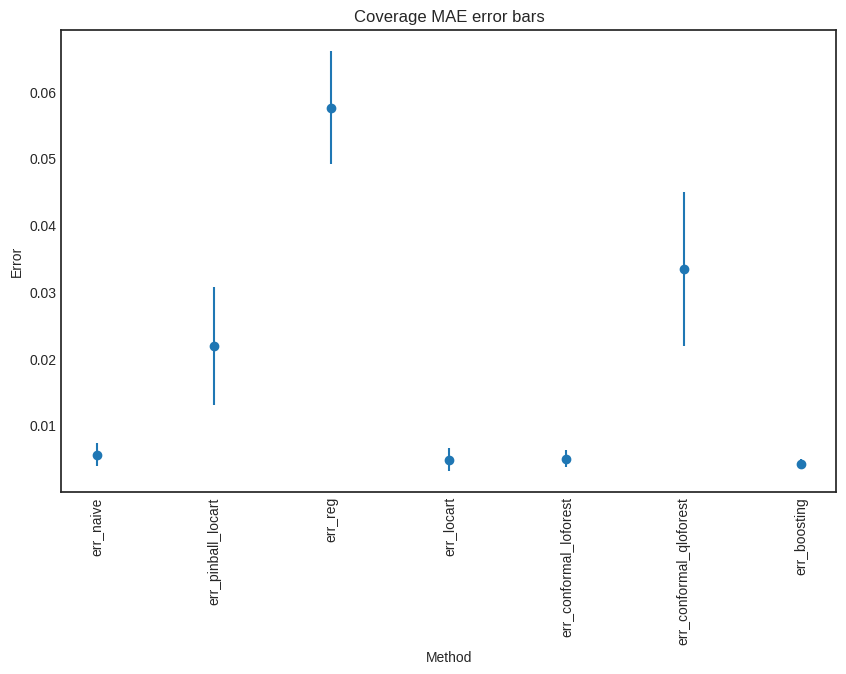

In [25]:
# Use seaborn-white style
plt.style.use('seaborn-white')

# Extract keys and values from the dictionary
keys = list(err.keys())
values = list(err.values())

# Separate mean absolute errors and standard errors
mae = [val[0] for val in values]
std_err = [val[1] for val in values]

# Create an error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(keys, mae, yerr=std_err, fmt='o')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title('Coverage MAE error bars')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

## Regressor - random

In [73]:
err_random = {}

Generating 1000 random thetas from the grid to compute the metrics of both the gradient boosting tree and the MSE-locart:

In [74]:
# aqui, a gente gera N (=1000) thetas aleatoriamente entre
# os possiveis valores do grid e computa as metricas
lambdas_r, thetas_r, data_melted = params_with_random_thetas(thetas, 1000)

Sorting thetas to obtain naive quantiles:

In [75]:
new_thetas = deepcopy(thetas_r)
new_thetas.sort()

Obtaining metrics for the naive method:

In [76]:
thetas_fixed = list(set(new_thetas))
naive_quantiles = train_naive_quantile(data_melted, thetas = thetas_fixed, alpha = alpha)
naive = predict_naive_quantile(thetas, naive_quantiles)

In [77]:
err_random["err_naive"] = eval_coverage(naive, thetas)

alpha for theta=0.5 : 0.1006 --- quantile: 0.008040659712633392
alpha for theta=1.0 : 0.0626 --- quantile: 0.009064720585721178
alpha for theta=1.5 : 0.0536 --- quantile: 0.008034919925785082
alpha for theta=2.0 : 0.1108 --- quantile: 0.005489716763387303
alpha for theta=2.5 : 0.096 --- quantile: 0.00459549958716964
alpha for theta=3.0 : 0.0632 --- quantile: 0.00391293163213605
alpha for theta=3.5 : 0.0619 --- quantile: 0.0031676165776814928
alpha for theta=4.0 : 0.0944 --- quantile: 0.0022671805556329075
alpha for theta=4.5 : 0.0777 --- quantile: 0.001870501730878845
alpha for theta=5.0 : 0.0415 --- quantile: 0.0016620530009145307
alpha for theta=5.5 : 0.0585 --- quantile: 0.0012132285615359317
alpha for theta=6.0 : 0.1515 --- quantile: 0.0007063743470000922
alpha for theta=6.5 : 0.1249 --- quantile: 0.000603439192977573
mean absolute error: 0.0357076923076923
standard error: 0.008097215983962772


Obtaining metrics first for the gradient boosting unique tree:

In [78]:
model = HistGradientBoostingRegressor(
    loss="quantile", quantile=.95, max_iter=1
)

model_thetas = np.array(thetas_r).reshape(-1, 1)
model_lambdas = np.array(lambdas_r).reshape(-1, 1)
model.fit(model_thetas, model_lambdas)

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor(loss='quantile', max_iter=1, quantile=0.95)

In [79]:
quantiles = model.predict(thetas.reshape(-1, 1))
quantiles

array([0.00614594, 0.00624835, 0.00614537, 0.00589085, 0.00580142,
       0.00561622, 0.00561622, 0.00561622, 0.00561622, 0.00561622,
       0.00561622, 0.00561622, 0.00561622])

In [80]:
err_random["err_reg"] = eval_coverage(quantiles, thetas)

alpha for theta=0.5 : 0.2099 --- quantile: 0.006145940643818421
alpha for theta=1.0 : 0.1992 --- quantile: 0.0062483467311272
alpha for theta=1.5 : 0.1347 --- quantile: 0.006145366665133591
alpha for theta=2.0 : 0.0867 --- quantile: 0.005890846348893812
alpha for theta=2.5 : 0.0367 --- quantile: 0.005801424631272046
alpha for theta=3.0 : 0.0095 --- quantile: 0.005616223557002448
alpha for theta=3.5 : 0.0013 --- quantile: 0.005616223557002448
alpha for theta=4.0 : 0.0002 --- quantile: 0.005616223557002448
alpha for theta=4.5 : 0.0 --- quantile: 0.005616223557002448
alpha for theta=5.0 : 0.0 --- quantile: 0.005616223557002448
alpha for theta=5.5 : 0.0 --- quantile: 0.005616223557002448
alpha for theta=6.0 : 0.0 --- quantile: 0.005616223557002448
alpha for theta=6.5 : 0.0 --- quantile: 0.005616223557002448
mean absolute error: 0.06406153846153848
standard error: 0.011453030081283538


Obtaining the metrics for locart:

In [81]:
# fitting locart to the new synthetic class
locart_object = LocartSplit(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas, min_samples_leaf = 50)
idxs = locart_object.cart.apply(thetas.reshape(-1, 1))
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

In [82]:
err_random["err_locart"] = eval_coverage(list_locart_quantiles, thetas)

alpha for theta=0.5 : 0.0855 --- quantile: 0.00833410798849554
alpha for theta=1.0 : 0.0299 --- quantile: 0.01054052941652833
alpha for theta=1.5 : 0.0367 --- quantile: 0.008571427227803293
alpha for theta=2.0 : 0.0733 --- quantile: 0.006038689382054141
alpha for theta=2.5 : 0.0139 --- quantile: 0.006622836461736646
alpha for theta=3.0 : 0.0433 --- quantile: 0.004315375700346861
alpha for theta=3.5 : 0.0538 --- quantile: 0.003302616577681494
alpha for theta=4.0 : 0.0513 --- quantile: 0.002590421717326419
alpha for theta=4.5 : 0.0565 --- quantile: 0.001997064067818297
alpha for theta=5.0 : 0.0305 --- quantile: 0.0017422762782190414
alpha for theta=5.5 : 0.034 --- quantile: 0.0013867714384640682
alpha for theta=6.0 : 0.1042 --- quantile: 0.000790516882548713
alpha for theta=6.5 : 0.0707 --- quantile: 0.0006968094233822517
mean absolute error: 0.019769230769230768
standard error: 0.004006066178518865


Obtaining metrics for loforest:

In [83]:
model_thetas = np.array(thetas_r).reshape(-1, 1)
model_lambdas = np.array(lambdas_r).reshape(-1, 1)

loforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 100)
loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1))

loforest_cutoffs

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


array([0.00843524, 0.00843524, 0.00833466, 0.0065976 , 0.00479518,
       0.00431811, 0.00361293, 0.00260217, 0.00211875, 0.00211875,
       0.00088719, 0.00088719, 0.00088719])

In [84]:
err_random["err_conformal_loforest"] = eval_coverage(loforest_cutoffs, thetas)

alpha for theta=0.5 : 0.0796 --- quantile: 0.008435239230598985
alpha for theta=1.0 : 0.0749 --- quantile: 0.008435239230598985
alpha for theta=1.5 : 0.0444 --- quantile: 0.008334655228896773
alpha for theta=2.0 : 0.055 --- quantile: 0.006597602218043556
alpha for theta=2.5 : 0.0807 --- quantile: 0.004795176800854647
alpha for theta=3.0 : 0.0516 --- quantile: 0.004318110148294893
alpha for theta=3.5 : 0.0332 --- quantile: 0.0036129316321360516
alpha for theta=4.0 : 0.0519 --- quantile: 0.002602166747562282
alpha for theta=4.5 : 0.0399 --- quantile: 0.002118750270189285
alpha for theta=5.0 : 0.0098 --- quantile: 0.002118750270189285
alpha for theta=5.5 : 0.1658 --- quantile: 0.0008871870248651305
alpha for theta=6.0 : 0.0697 --- quantile: 0.0008871870248651305
alpha for theta=6.5 : 0.0276 --- quantile: 0.0008871870248651305
mean absolute error: 0.024946153846153847
standard error: 0.007961048780069917


Obtaining metrics for pinball loforest:

In [85]:
model_thetas = np.array(thetas_r).reshape(-1, 1)
model_lambdas = np.array(lambdas_r)

qloforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
qloforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 50, objective = "quantile", colsample_bynode = 1, max_features = 1)
qloforest_cutoffs = qloforest_object.compute_cutoffs(thetas.reshape(-1, 1))

In [86]:
err_random["err_conformal_qloforest"] = eval_coverage(qloforest_cutoffs, thetas)

alpha for theta=0.5 : 0.0922 --- quantile: 0.00833410798849554
alpha for theta=1.0 : 0.0284 --- quantile: 0.01054052941652833
alpha for theta=1.5 : 0.0386 --- quantile: 0.008571427227803293
alpha for theta=2.0 : 0.0771 --- quantile: 0.006038689382054141
alpha for theta=2.5 : 0.0142 --- quantile: 0.006622836461736646
alpha for theta=3.0 : 0.1979 --- quantile: 0.002797631804487945
alpha for theta=3.5 : 0.1016 --- quantile: 0.002797631804487945
alpha for theta=4.0 : 0.0367 --- quantile: 0.002797631804487945
alpha for theta=4.5 : 0.0076 --- quantile: 0.002797631804487945
alpha for theta=5.0 : 0.0005 --- quantile: 0.002797631804487945
alpha for theta=5.5 : 0.0 --- quantile: 0.002797631804487945
alpha for theta=6.0 : 0.0 --- quantile: 0.002797631804487945
alpha for theta=6.5 : 0.0 --- quantile: 0.002797631804487945
mean absolute error: 0.0456
standard error: 0.009044138969749526


Obtaining metrics for boosting:

In [87]:
# boosting com os parametros gerados aleatoriamente
model_r = HistGradientBoostingRegressor(
    loss="quantile", quantile=.95
)

model_thetas = np.array(thetas_r).reshape(-1, 1)
model_lambdas = np.array(lambdas_r).reshape(-1, 1)
model_r.fit(model_thetas, model_lambdas)

boosting_quantiles_r = model_r.predict(thetas.reshape(-1, 1))

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [88]:
err_random["err_boosting"] = eval_coverage(boosting_quantiles_r, thetas)

alpha for theta=0.5 : 0.0971 --- quantile: 0.00804060379442343
alpha for theta=1.0 : 0.0675 --- quantile: 0.00890467327119382
alpha for theta=1.5 : 0.0595 --- quantile: 0.0079103412720479
alpha for theta=2.0 : 0.1074 --- quantile: 0.005551120204557833
alpha for theta=2.5 : 0.0935 --- quantile: 0.004595535177232001
alpha for theta=3.0 : 0.0746 --- quantile: 0.003912978066001455
alpha for theta=3.5 : 0.0668 --- quantile: 0.0031676874518067233
alpha for theta=4.0 : 0.0983 --- quantile: 0.0022804634142282805
alpha for theta=4.5 : 0.0708 --- quantile: 0.0018902457756369442
alpha for theta=5.0 : 0.0383 --- quantile: 0.0016621638328714172
alpha for theta=5.5 : 0.0494 --- quantile: 0.0012134188194159448
alpha for theta=6.0 : 0.1595 --- quantile: 0.0007066071288035281
alpha for theta=6.5 : 0.0917 --- quantile: 0.0006037189930793961
mean absolute error: 0.03453846153846153
standard error: 0.007620227973895962


### Plotting results:

/tmp/ipykernel_18369/3233925417.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


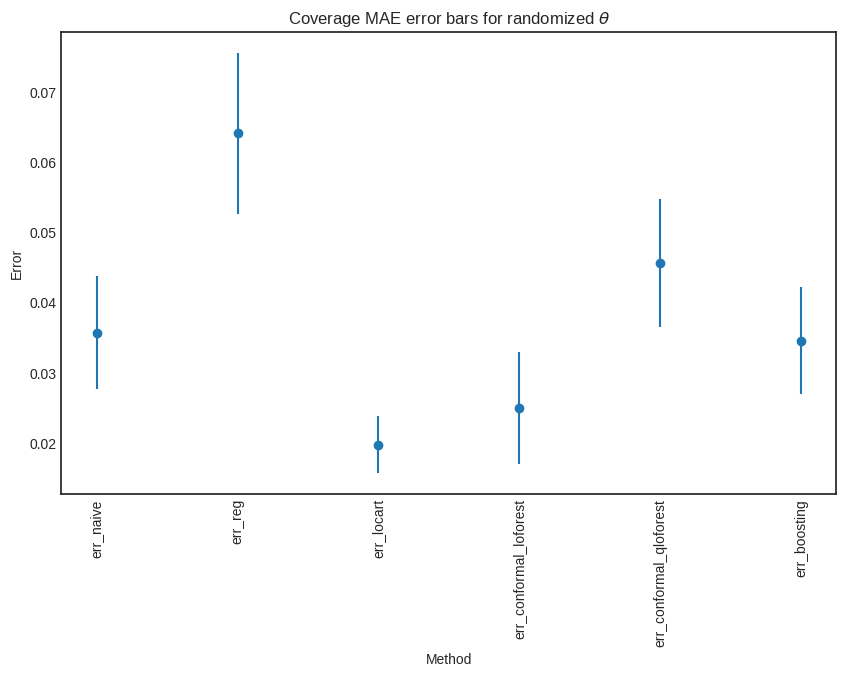

In [93]:
# Use seaborn-white style
plt.style.use('seaborn-white')

# Extract keys and values from the dictionary
keys = list(err_random.keys())
values = list(err_random.values())

# Separate mean absolute errors and standard errors
mae = [val[0] for val in values]
std_err = [val[1] for val in values]

# Create an error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(keys, mae, yerr=std_err, fmt='o')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title(r'Coverage MAE error bars for randomized $\theta$')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

## 30 iters in each theta

In [94]:
err_few = {}

Making less iterations for each theta and testing the gradient boosting, naive and so on:

In [95]:
# Aqui foi uma tentativa de fazer poucas iteracoes em cima de cada theta,
# que é algo mais proximo do que acontece na realidade
lambdas_few, thetas_few, data_melted = generate_parameters(thetas, N, 30)

Obtaining naive cutoffs:

In [97]:
new_thetas = deepcopy(thetas_few)
new_thetas.sort()

thetas_fixed = list(set(new_thetas))
naive_quantiles = train_naive_quantile(data_melted, thetas = thetas_fixed, alpha = alpha)
naive = predict_naive_quantile(thetas, naive_quantiles)

In [98]:
err_few["err_naive"] = eval_coverage(naive, thetas)

alpha for theta=0.5 : 0.0948 --- quantile: 0.00825193402873664
alpha for theta=1.0 : 0.0682 --- quantile: 0.008840558828557677
alpha for theta=1.5 : 0.1588 --- quantile: 0.005871983985157008
alpha for theta=2.0 : 0.0835 --- quantile: 0.005953528323661271
alpha for theta=2.5 : 0.1175 --- quantile: 0.004263499862389876
alpha for theta=3.0 : 0.0326 --- quantile: 0.0046812931632136
alpha for theta=3.5 : 0.072 --- quantile: 0.0031002616577681516
alpha for theta=4.0 : 0.0771 --- quantile: 0.002325638888734185
alpha for theta=4.5 : 0.0651 --- quantile: 0.0019560034617576894
alpha for theta=5.0 : 0.0663 --- quantile: 0.0015137946999085458
alpha for theta=5.5 : 0.0502 --- quantile: 0.0012536771438464067
alpha for theta=6.0 : 0.0677 --- quantile: 0.0009078752176666354
alpha for theta=6.5 : 0.0509 --- quantile: 0.0007584391929775727
mean absolute error: 0.029961538461538463
standard error: 0.007887226873047817


In [99]:
model = HistGradientBoostingRegressor(
    loss="quantile", quantile=.95, max_iter=1
)

model_thetas = np.array(thetas_few).reshape(-1, 1)
model_lambdas = np.array(lambdas_few).reshape(-1, 1)
model.fit(model_thetas, model_lambdas)

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor(loss='quantile', max_iter=1, quantile=0.95)

In [100]:
quantiles = model.predict(thetas.reshape(-1, 1))
quantiles

array([0.00583355, 0.00589241, 0.00559555, 0.00560371, 0.0054347 ,
       0.00547648, 0.00531838, 0.00519838, 0.00519838, 0.00519838,
       0.00519838, 0.00519838, 0.0050842 ])

In [101]:
err_few["err_reg"] = eval_coverage(quantiles, thetas)

alpha for theta=0.5 : 0.232 --- quantile: 0.0058335471190254454
alpha for theta=1.0 : 0.2237 --- quantile: 0.00589240959900755
alpha for theta=1.5 : 0.1779 --- quantile: 0.005595552114667482
alpha for theta=2.0 : 0.0993 --- quantile: 0.005603706548517908
alpha for theta=2.5 : 0.0459 --- quantile: 0.005434703702390769
alpha for theta=3.0 : 0.0102 --- quantile: 0.005476483032473141
alpha for theta=3.5 : 0.001 --- quantile: 0.005318379881928597
alpha for theta=4.0 : 0.0 --- quantile: 0.0051983775370432195
alpha for theta=4.5 : 0.0 --- quantile: 0.0051983775370432195
alpha for theta=5.0 : 0.0 --- quantile: 0.0051983775370432195
alpha for theta=5.5 : 0.0 --- quantile: 0.0051983775370432195
alpha for theta=6.0 : 0.0 --- quantile: 0.0051983775370432195
alpha for theta=6.5 : 0.0 --- quantile: 0.005084197635449539
mean absolute error: 0.07121538461538464
standard error: 0.014422869110928929


Testing also for MSE-locart:

In [102]:
# fitting locart to the new synthetic class
# changing minimal sample leaves to a new strategic value
locart_object = LocartSplit(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas, min_samples_leaf = 10)
idxs = locart_object.cart.apply(thetas.reshape(-1, 1))
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

In [103]:
err_few["err_locart"] = eval_coverage(list_locart_quantiles, thetas)

alpha for theta=0.5 : 0.0669 --- quantile: 0.009069340287366612
alpha for theta=1.0 : 0.0294 --- quantile: 0.01037944117144235
alpha for theta=1.5 : 0.0584 --- quantile: 0.008030160148429832
alpha for theta=2.0 : 0.0156 --- quantile: 0.0083352832366127
alpha for theta=2.5 : 0.0489 --- quantile: 0.0054849986238987986
alpha for theta=3.0 : 0.0086 --- quantile: 0.00588706836786395
alpha for theta=3.5 : 0.0617 --- quantile: 0.0032973834223185075
alpha for theta=4.0 : 0.0044 --- quantile: 0.003815638888734185
alpha for theta=4.5 : 0.0884 --- quantile: 0.0018010034617576898
alpha for theta=5.0 : 0.0295 --- quantile: 0.0018010034617576898
alpha for theta=5.5 : 0.0026 --- quantile: 0.0019132285615359318
alpha for theta=6.0 : 0.045 --- quantile: 0.0009793457976782281
alpha for theta=6.5 : 0.014 --- quantile: 0.0009793457976782281
mean absolute error: 0.025184615384615385
standard error: 0.00429147836148365


Testing for conformal loforest:

In [104]:
model_thetas = np.array(thetas_few).reshape(-1, 1)
model_lambdas = np.array(lambdas_few).reshape(-1, 1)


loforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 10)
loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1))

loforest_cutoffs

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


array([0.00906934, 0.01037944, 0.00803016, 0.00833528, 0.005485  ,
       0.00588707, 0.00329738, 0.00381564, 0.002109  , 0.00166205,
       0.00191323, 0.00112125, 0.00099656])

In [105]:
err_few["err_conformal_loforest"] = eval_coverage(loforest_cutoffs, thetas)

alpha for theta=0.5 : 0.0628 --- quantile: 0.009069340287366612
alpha for theta=1.0 : 0.0325 --- quantile: 0.01037944117144235
alpha for theta=1.5 : 0.0555 --- quantile: 0.008030160148429832
alpha for theta=2.0 : 0.0145 --- quantile: 0.0083352832366127
alpha for theta=2.5 : 0.0461 --- quantile: 0.0054849986238987986
alpha for theta=3.0 : 0.0091 --- quantile: 0.00588706836786395
alpha for theta=3.5 : 0.0561 --- quantile: 0.0032973834223185075
alpha for theta=4.0 : 0.0052 --- quantile: 0.003815638888734185
alpha for theta=4.5 : 0.0406 --- quantile: 0.0021089965382423102
alpha for theta=5.0 : 0.047 --- quantile: 0.0016620530009145307
alpha for theta=5.5 : 0.0034 --- quantile: 0.0019132285615359318
alpha for theta=6.0 : 0.028 --- quantile: 0.0011212478233336405
alpha for theta=6.5 : 0.015 --- quantile: 0.000996560807022427
mean absolute error: 0.02176923076923077
standard error: 0.004425643196865591


Obtaining metrics for pinball loforest:

In [106]:
model_thetas = np.array(thetas_few).reshape(-1, 1)
model_lambdas = np.array(lambdas_few)

qloforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
qloforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 10, objective = "quantile", colsample_bynode = 1, max_features = 1)
qloforest_cutoffs = qloforest_object.compute_cutoffs(thetas.reshape(-1, 1))

In [107]:
err_few["err_conformal_qloforest"] = eval_coverage(qloforest_cutoffs, thetas)

alpha for theta=0.5 : 0.0665 --- quantile: 0.009069340287366612
alpha for theta=1.0 : 0.0323 --- quantile: 0.01037944117144235
alpha for theta=1.5 : 0.0562 --- quantile: 0.008030160148429832
alpha for theta=2.0 : 0.0163 --- quantile: 0.0083352832366127
alpha for theta=2.5 : 0.2055 --- quantile: 0.003418112364892213
alpha for theta=3.0 : 0.116 --- quantile: 0.003418112364892213
alpha for theta=3.5 : 0.0454 --- quantile: 0.003418112364892213
alpha for theta=4.0 : 0.0091 --- quantile: 0.003418112364892213
alpha for theta=4.5 : 0.0007 --- quantile: 0.003418112364892213
alpha for theta=5.0 : 0.0002 --- quantile: 0.003418112364892213
alpha for theta=5.5 : 0.0 --- quantile: 0.003418112364892213
alpha for theta=6.0 : 0.0 --- quantile: 0.003418112364892213
alpha for theta=6.5 : 0.0 --- quantile: 0.003418112364892213
mean absolute error: 0.0454
standard error: 0.010206547382315707


Testing for boosting:

In [108]:
# boosting com poucas observacoes sobre cada theta
model = HistGradientBoostingRegressor(
    loss="quantile", quantile=.95,
)

model_thetas = np.array(thetas_few).reshape(-1, 1)
model_lambdas = np.array(lambdas_few).reshape(-1, 1)
model.fit(model_thetas, model_lambdas)

quantiles = model.predict(thetas.reshape(-1, 1))

/home/kuben45/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [109]:
err_few["err_boosting"] = eval_coverage(quantiles, thetas)

alpha for theta=0.5 : 0.0912 --- quantile: 0.008269529141730092
alpha for theta=1.0 : 0.0606 --- quantile: 0.009055161300493214
alpha for theta=1.5 : 0.1461 --- quantile: 0.006069220299636297
alpha for theta=2.0 : 0.0644 --- quantile: 0.006337768392053191
alpha for theta=2.5 : 0.1127 --- quantile: 0.004380939518170935
alpha for theta=3.0 : 0.0261 --- quantile: 0.004797320096105731
alpha for theta=3.5 : 0.064 --- quantile: 0.0031027290797136678
alpha for theta=4.0 : 0.0719 --- quantile: 0.0024079635421097386
alpha for theta=4.5 : 0.0547 --- quantile: 0.0020051272199606194
alpha for theta=5.0 : 0.0487 --- quantile: 0.0016255357623683633
alpha for theta=5.5 : 0.0411 --- quantile: 0.0012867751446389653
alpha for theta=6.0 : 0.0454 --- quantile: 0.0009787894213087716
alpha for theta=6.5 : 0.051 --- quantile: 0.0007592131329563885
mean absolute error: 0.02348461538461538
standard error: 0.007452324574028442


Plotting:

/tmp/ipykernel_18369/3357109697.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


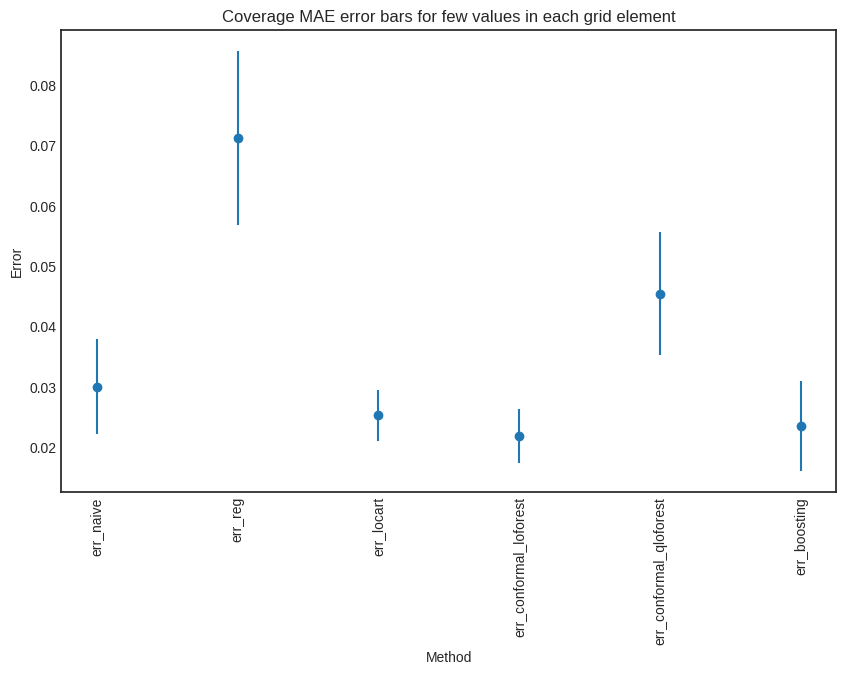

In [110]:
# Use seaborn-white style
plt.style.use('seaborn-white')

# Extract keys and values from the dictionary
keys = list(err_few.keys())
values = list(err_few.values())

# Separate mean absolute errors and standard errors
mae = [val[0] for val in values]
std_err = [val[1] for val in values]

# Create an error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(keys, mae, yerr=std_err, fmt='o')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title(r'Coverage MAE error bars for few values in each grid element')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

# Comparing naive to locart, conformal loforest and boosting for out of grid points:

In [87]:
def eval_coverage_new_grid(theta_grid, quantiles, iters = 10000, N = 10000):
    # theta = parametro
    # lambda = estatistica de teste
    # Lambda: |P_teorica(exp > 1) - P_empirica(exp > 1)|
    j = 0
    err = 0
    err_each = np.zeros(theta_grid.shape[0])
    # computando erro padrao tambem
    for theta in theta_grid:
        theoretical = np.e**(-theta)
        lambdas_ = []
        for i in range(iters):
            distr = np.random.exponential(1/theta, N)
            empirical = len([i for i in distr if i > 1])/len(distr)
            diff = abs(theoretical - empirical)
            lambdas_.append(diff)
        alpha = len([i for i in lambdas_ if i >= quantiles[j]])/len(lambdas_)
        print(f"alpha for theta={theta} : {alpha} --- quantile: {quantiles[j]}")
        err += abs(alpha - 0.05)
        err_each[j] = abs(alpha - 0.05)
        j += 1
    print(f"mean absolute error: {err/j}")
    standard_error = np.std(err_each)
    print(f"standard error: {standard_error/np.sqrt(j)}")
    return [err/j, standard_error/np.sqrt(j)]

Generating random grid points:

In [ ]:
np.random.seed(1250)
random_theta_grid = np.random.uniform(0, 7, 20)
err_random_grid = {}

# model thetas for locart, loforest and boosting
model_thetas = np.array(thetas_).reshape(-1, 1)
model_lambdas = np.array(lambdas)

Obtaining the quantiles for each method: Locart, Loforest, Boosting and Naive.

In [ ]:
# naive quantiles
naive_quantiles = train_naive_quantile(df_melted, thetas = thetas, alpha = alpha)
naive = predict_naive_quantile(random_theta_grid, naive_quantiles)
err_random_grid["naive"] = eval_coverage_new_grid(random_theta_grid, naive)

# locart quantiles
locart_object = LocartSplit(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas)
idxs = locart_object.cart.apply(random_theta_grid.reshape(-1, 1))
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]
err_random_grid["locart"] = eval_coverage_new_grid(random_theta_grid, list_locart_quantiles)

# loforest quantiles
loforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 100)
loforest_cutoffs = loforest_object.compute_cutoffs(random_theta_grid.reshape(-1, 1))
err_random_grid["c-loforest"] = eval_coverage_new_grid(random_theta_grid, loforest_cutoffs)

# boosting quantiles
model = HistGradientBoostingRegressor(loss="quantile", quantile=.95)
model.fit(model_thetas, model_lambdas)
boosting_quantiles = model.predict(random_theta_grid.reshape(-1, 1))
err_random_grid["boosting"] = eval_coverage_new_grid(random_theta_grid, boosting_quantiles)

alpha for theta=0.30275232042893696 : 0.0274 --- quantile: 0.009530659712633449
alpha for theta=1.2411049560396177 : 0.0366 --- quantile: 0.009479441171442338
alpha for theta=0.4083525026586644 : 0.0431 --- quantile: 0.009530659712633449
alpha for theta=1.1196895413602677 : 0.043 --- quantile: 0.009479441171442338
alpha for theta=3.4200838573417056 : 0.0593 --- quantile: 0.003302616577681494
alpha for theta=1.9261873242851286 : 0.0571 --- quantile: 0.0066352832366126935
alpha for theta=1.830834771124082 : 0.0723 --- quantile: 0.0066352832366126935
alpha for theta=4.820033691255512 : 0.0707 --- quantile: 0.0016379469990854684
alpha for theta=5.262142812213676 : 0.0918 --- quantile: 0.0012132285615359317
alpha for theta=2.429114271837263 : 0.0627 --- quantile: 0.005284998623898807
alpha for theta=0.7075902889591793 : 0.0585 --- quantile: 0.009530659712633449
alpha for theta=2.25966809806648 : 0.0854 --- quantile: 0.005284998623898807
alpha for theta=5.3851792923277175 : 0.0778 --- quanti

Plotting results:

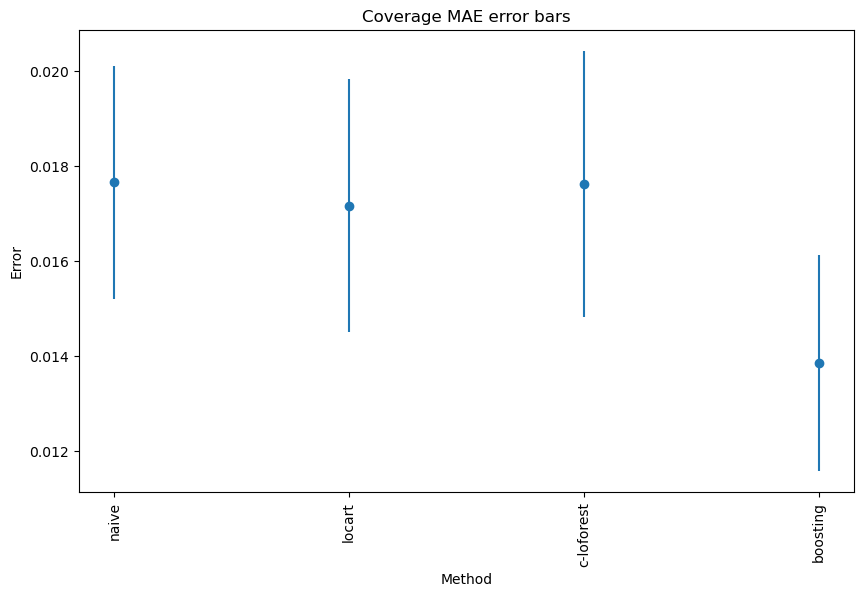

In [ ]:
# Extract keys and values from the dictionary
keys = list(err_random_grid.keys())
values = list(err_random_grid.values())

# Separate mean absolute errors and standard errors
mae = [val[0] for val in values]
std_err = [val[1] for val in values]

# Create an error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(keys, mae, yerr=std_err, fmt='o')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title('Coverage MAE error bars')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

# Generating random thetas and lambdas for training:

In [41]:
# fixing coarse grid
thetas = np.arange(0.5, 7, 0.5)

In [42]:
err_random_thetas = {}

New functions to generate random thetas and lambdas and deriving naive quantiles from random thetas:

In [102]:
def generate_parameters_random(n = 5000, random_seed = 45, N = 10000):
    np.random.seed(random_seed)
    random_theta_grid = np.random.uniform(0, 7, n)
    lambdas = []
    for theta in random_theta_grid:
        theoretical = np.e**(-theta)
        exp = np.random.exponential(1/theta, N)
        empirical = (len([i for i in exp if i > 1])/len(exp))
        lambdas.append(np.abs(theoretical - empirical))

    values = pd.DataFrame({"theta": random_theta_grid,
                           "value": lambdas})
    return random_theta_grid, lambdas, values

def train_naive_quantile_random(n_random, n_grid = 1000, N = 10000, lower = 0.1, upper = 7, alpha = 0.05):
    # simulating by the a fixed theta_grid with size compatible with the amount we want to simulate
    if int(n_random/n_grid) > 1:
        step = (upper - lower)/int(n_random/n_grid)
        thetas_fixed = np.arange(lower, upper, step)[:-1]
    else:
        step = (upper - lower)/2
        thetas_fixed = np.array([np.arange(lower, upper, step)[1]])

    quantiles = {}
    for theta in thetas_fixed:
        diff = []
        theoretical = np.e**(-theta)
        for i in range(n_grid):
            exp = np.random.exponential(1/theta, N)
            empirical = (len([i for i in exp if i > 1])/len(exp))
            diff.append(abs(theoretical - empirical))
        quantiles[theta] = np.quantile(np.array(diff), q = 1 - alpha)
    return quantiles

generating $\theta$ random sample:

In [44]:
random_theta_grid, lambdas, data_melted = generate_parameters_random(n = 10000)

Obtaining naive quantiles and metrics:

In [45]:
naive_quantiles = train_naive_quantile_random(n_random = 10000, alpha = alpha)
naive = predict_naive_quantile(thetas, naive_quantiles)

In [46]:
err_random_thetas["err_naive"] = eval_coverage(naive, thetas)

alpha for theta=0.5 : 0.0512 --- quantile: 0.009349795282355817
alpha for theta=1.0 : 0.0521 --- quantile: 0.009349795282355817
alpha for theta=1.5 : 0.0467 --- quantile: 0.008362311616187279
alpha for theta=2.0 : 0.0645 --- quantile: 0.0062776169108364616
alpha for theta=2.5 : 0.0243 --- quantile: 0.0062776169108364616
alpha for theta=3.0 : 0.0404 --- quantile: 0.0044312397345326535
alpha for theta=3.5 : 0.0553 --- quantile: 0.0032753603457605744
alpha for theta=4.0 : 0.0899 --- quantile: 0.0022924081568876462
alpha for theta=4.5 : 0.029 --- quantile: 0.0022924081568876462
alpha for theta=5.0 : 0.0366 --- quantile: 0.0017265032813764646
alpha for theta=5.5 : 0.0507 --- quantile: 0.0012246411089657573
alpha for theta=6.0 : 0.0111 --- quantile: 0.0012246411089657573
alpha for theta=6.5 : 0.0013 --- quantile: 0.0012246411089657573
mean absolute error: 0.017253846153846154
standard error: 0.004375599575275341


In [49]:
# model thetas for locart, loforest and boosting
model_thetas = random_theta_grid.reshape(-1, 1)
model_lambdas = np.array(lambdas)

In [50]:
# locart quantiles
locart_object = LocartSplit(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas, min_samples_leaf = 300)
idxs = locart_object.cart.apply(thetas.reshape(-1, 1))
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]
err_random_thetas["locart"] = eval_coverage(list_locart_quantiles, thetas)

# loforest quantiles
loforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 300)
loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1))
err_random_thetas["c-loforest"] = eval_coverage(loforest_cutoffs, thetas)

# boosting quantiles
model = HistGradientBoostingRegressor(loss="quantile", quantile=.95, random_state = 105)
model.fit(model_thetas, model_lambdas)
boosting_quantiles = model.predict(thetas.reshape(-1, 1))
err_random_thetas["boosting"] = eval_coverage(boosting_quantiles, thetas)

alpha for theta=0.5 : 0.0485 --- quantile: 0.009724446578683129
alpha for theta=1.0 : 0.0439 --- quantile: 0.009713847855581766
alpha for theta=1.5 : 0.0555 --- quantile: 0.008055168846910085
alpha for theta=2.0 : 0.0452 --- quantile: 0.006841111163422182
alpha for theta=2.5 : 0.0398 --- quantile: 0.005628856227659591
alpha for theta=3.0 : 0.0478 --- quantile: 0.0042836134438679375
alpha for theta=3.5 : 0.0642 --- quantile: 0.0031185564785325103
alpha for theta=4.0 : 0.0461 --- quantile: 0.002653232460549893
alpha for theta=4.5 : 0.0509 --- quantile: 0.002009007844382085
alpha for theta=5.0 : 0.0429 --- quantile: 0.0016494980637133318
alpha for theta=5.5 : 0.0348 --- quantile: 0.0013310895023023294
alpha for theta=6.0 : 0.07 --- quantile: 0.0008870093628994546
alpha for theta=6.5 : 0.049 --- quantile: 0.0007328160550229512
mean absolute error: 0.007123076923076923
standard error: 0.0016174768079935196
alpha for theta=0.5 : 0.0454 --- quantile: 0.009761984471854874
alpha for theta=1.0 :

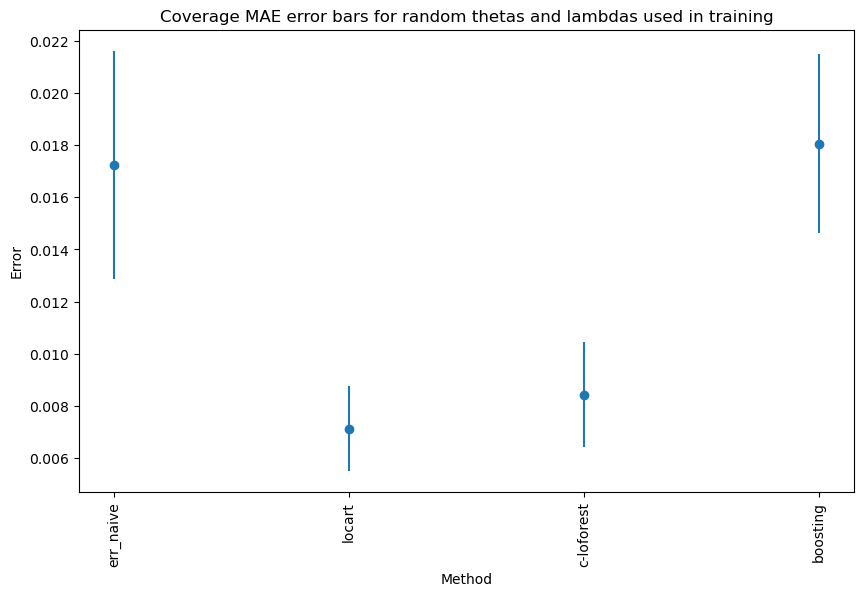

In [52]:
# Extract keys and values from the dictionary
keys = list(err_random_thetas.keys())
values = list(err_random_thetas.values())

# Separate mean absolute errors and standard errors
mae = [val[0] for val in values]
std_err = [val[1] for val in values]

# Create an error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(keys, mae, yerr=std_err, fmt='o')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title('Coverage MAE error bars for random thetas and lambdas used in training')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

# Thinner grid for $\theta$

Increasing the number of grid elements in the interval between 0 and 7:

In [78]:
# Fica a vontade pra mudar isso aqui se quiser brincar
thetas = np.arange(0.1, 7, 0.1)
N = 10000
# decreasing number of iteration for each theta
iters = 700

np.random.seed(1250)
lambdas, thetas_, df_melted = generate_parameters(thetas, N, iters)

In [79]:
err_thin = {}

Fitting the naive method in this case:

In [80]:
naive_quantiles = train_naive_quantile(df_melted, thetas = thetas, alpha = alpha)
naive = predict_naive_quantile(thetas, naive_quantiles)

In [81]:
err_thin["err_naive"] = eval_coverage(naive, thetas, iters = 1000, verbose = False)

Fitting the remaining methods:

In [82]:
# model thetas for locart, loforest and boosting
model_thetas = np.array(thetas_).reshape(-1, 1)
model_lambdas = np.array(lambdas)

In [83]:
# locart quantiles
locart_object = LocartSplit(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas, min_samples_leaf = 150)
idxs = locart_object.cart.apply(thetas.reshape(-1, 1))
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]
err_thin["locart"] = eval_coverage(list_locart_quantiles, thetas,  iters = 1000, verbose = False)

# loforest quantiles
loforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 150)
loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1))
err_thin["c-loforest"] = eval_coverage(loforest_cutoffs, thetas, iters = 1000, verbose = False)

# boosting quantiles
model = HistGradientBoostingRegressor(loss="quantile", quantile=.95, random_state = 105)
model.fit(model_thetas, model_lambdas)
boosting_quantiles = model.predict(thetas.reshape(-1, 1))
err_thin["boosting"] = eval_coverage(boosting_quantiles, thetas, iters = 1000, verbose = False)

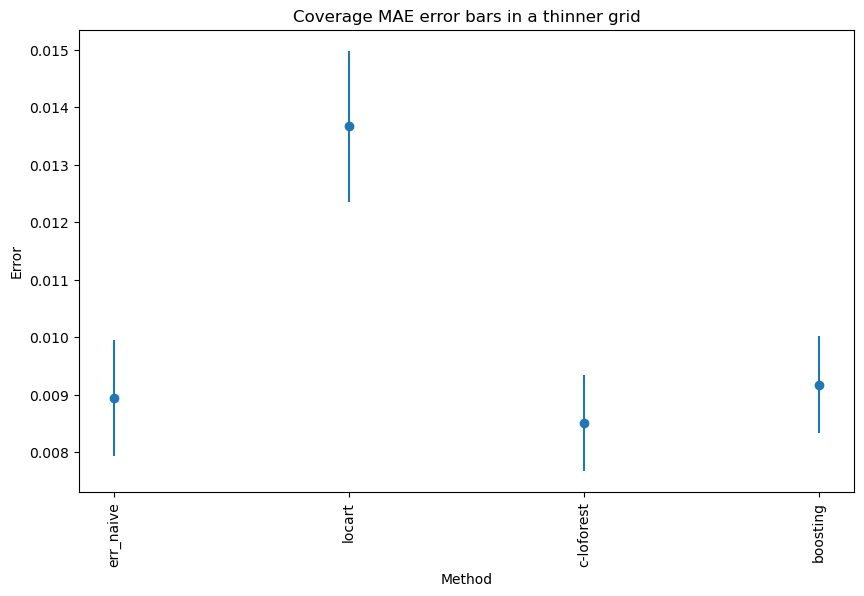

In [84]:
# Extract keys and values from the dictionary
keys = list(err_thin.keys())
values = list(err_thin.values())

# Separate mean absolute errors and standard errors
mae = [val[0] for val in values]
std_err = [val[1] for val in values]

# Create an error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(keys, mae, yerr=std_err, fmt='o')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title('Coverage MAE error bars in a thinner grid')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

# Randomly sampling theta and lambda and evaluating using the thinner grid

In [70]:
# Fica a vontade pra mudar isso aqui se quiser brincar
thetas = np.arange(0.1, 7, 0.1)
err_random_thin_thetas = {}

Generating random $\theta$ and $\lambda$:

In [71]:
random_theta_grid, lambdas, data_melted = generate_parameters_random(n = 10000)

In [72]:
naive_quantiles = train_naive_quantile_random(n_random = len(lambdas), alpha = alpha)
naive = predict_naive_quantile(thetas, naive_quantiles)
err_random_thin_thetas["err_naive"] = eval_coverage(naive, thetas, iters = 1000, verbose = False)

In [73]:
# model thetas for locart, loforest and boosting
model_thetas = random_theta_grid.reshape(-1, 1)
model_lambdas = np.array(lambdas)

In [74]:
# locart quantiles
locart_object = LocartSplit(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas, min_samples_leaf = 150)
idxs = locart_object.cart.apply(thetas.reshape(-1, 1))
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]
err_random_thin_thetas["locart"] = eval_coverage(list_locart_quantiles, thetas, iters = 1000, verbose = False)

# loforest quantiles
loforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 150)
loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 1))
err_random_thin_thetas["c-loforest"] = eval_coverage(loforest_cutoffs, thetas, iters = 1000, verbose = False)

# boosting quantiles
model = HistGradientBoostingRegressor(loss="quantile", quantile=.95, random_state = 105)
model.fit(model_thetas, model_lambdas)
boosting_quantiles = model.predict(thetas.reshape(-1, 1))
err_random_thin_thetas["boosting"] = eval_coverage(boosting_quantiles, thetas, iters = 1000, verbose = False)

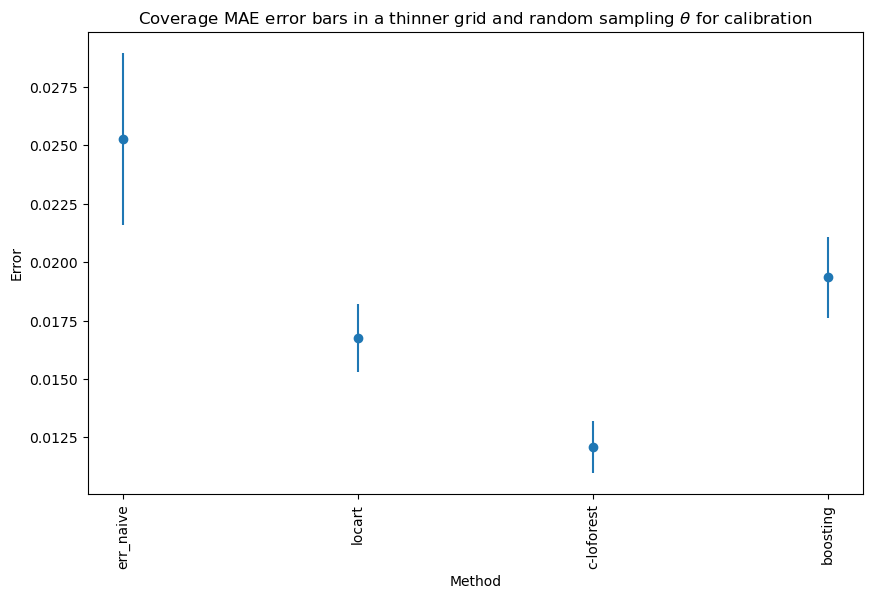

In [75]:
# Extract keys and values from the dictionary
keys = list(err_random_thin_thetas.keys())
values = list(err_random_thin_thetas.values())

# Separate mean absolute errors and standard errors
mae = [val[0] for val in values]
std_err = [val[1] for val in values]

# Create an error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(keys, mae, yerr=std_err, fmt='o')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title(r'Coverage MAE error bars in a thinner grid and random sampling $\theta$ for calibration')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

# Random thetas and lambdas for both training and validating coverage:

In [85]:
np.random.seed(1250)
random_theta_grid_valid = np.random.uniform(0, 7, 20)
err_random_thetas_validation = {}

# training thetas and lambdas
random_theta_grid, lambdas, data_melted = generate_parameters_random(n = 10000)

# model thetas for locart, loforest and boosting
model_thetas = random_theta_grid.reshape(-1, 1)
model_lambdas = np.array(lambdas)

In [88]:
naive_quantiles = train_naive_quantile_random(n_random = 10000, alpha = alpha)
naive = predict_naive_quantile(random_theta_grid_valid, naive_quantiles)

err_random_thetas_validation["naive"] = eval_coverage_new_grid(random_theta_grid_valid, naive)

alpha for theta=0.30275232042893696 : 0.2078 --- quantile: 0.0055625819640404695
alpha for theta=1.2411049560396177 : 0.0733 --- quantile: 0.008137688383812708
alpha for theta=0.4083525026586644 : 0.2418 --- quantile: 0.0055625819640404695
alpha for theta=1.1196895413602677 : 0.0526 --- quantile: 0.009245315754120251
alpha for theta=3.4200838573417056 : 0.0705 --- quantile: 0.003224639654239428
alpha for theta=1.9261873242851286 : 0.0661 --- quantile: 0.006422383089163541
alpha for theta=1.830834771124082 : 0.0747 --- quantile: 0.006422383089163541
alpha for theta=4.820033691255512 : 0.0762 --- quantile: 0.0016265032813764643
alpha for theta=5.262142812213676 : 0.0204 --- quantile: 0.0016265032813764643
alpha for theta=2.429114271837263 : 0.0224 --- quantile: 0.006422383089163541
alpha for theta=0.7075902889591793 : 0.0612 --- quantile: 0.009245315754120251
alpha for theta=2.25966809806648 : 0.0322 --- quantile: 0.006422383089163541
alpha for theta=5.3851792923277175 : 0.0846 --- quant

In [89]:
# locart quantiles
locart_object = LocartSplit(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas, min_samples_leaf = 300)
idxs = locart_object.cart.apply(random_theta_grid_valid.reshape(-1, 1))
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]
err_random_thetas_validation["locart"] = eval_coverage_new_grid(random_theta_grid_valid, list_locart_quantiles)

# loforest quantiles
loforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 300)
loforest_cutoffs = loforest_object.compute_cutoffs(random_theta_grid_valid.reshape(-1, 1))
err_random_thetas_validation["c-loforest"] = eval_coverage_new_grid(random_theta_grid_valid, loforest_cutoffs)

# boosting quantiles
model = HistGradientBoostingRegressor(loss="quantile", quantile=.95, random_state = 105)
model.fit(model_thetas, model_lambdas)
boosting_quantiles = model.predict(random_theta_grid_valid.reshape(-1, 1))
err_random_thetas_validation["boosting"] = eval_coverage_new_grid(random_theta_grid_valid, boosting_quantiles)

alpha for theta=0.30275232042893696 : 0.0388 --- quantile: 0.009093149596122771
alpha for theta=1.2411049560396177 : 0.0625 --- quantile: 0.008445888352873531
alpha for theta=0.4083525026586644 : 0.055 --- quantile: 0.009093149596122771
alpha for theta=1.1196895413602677 : 0.0781 --- quantile: 0.008445888352873531
alpha for theta=3.4200838573417056 : 0.0738 --- quantile: 0.0031185564785325103
alpha for theta=1.9261873242851286 : 0.0395 --- quantile: 0.007146635718579916
alpha for theta=1.830834771124082 : 0.045 --- quantile: 0.007146635718579916
alpha for theta=4.820033691255512 : 0.0639 --- quantile: 0.0016494980637133318
alpha for theta=5.262142812213676 : 0.0339 --- quantile: 0.0014911403827139087
alpha for theta=2.429114271837263 : 0.0464 --- quantile: 0.005628856227659591
alpha for theta=0.7075902889591793 : 0.0463 --- quantile: 0.00981781096911532
alpha for theta=2.25966809806648 : 0.026 --- quantile: 0.006841111163422182
alpha for theta=5.3851792923277175 : 0.0463 --- quantile: 

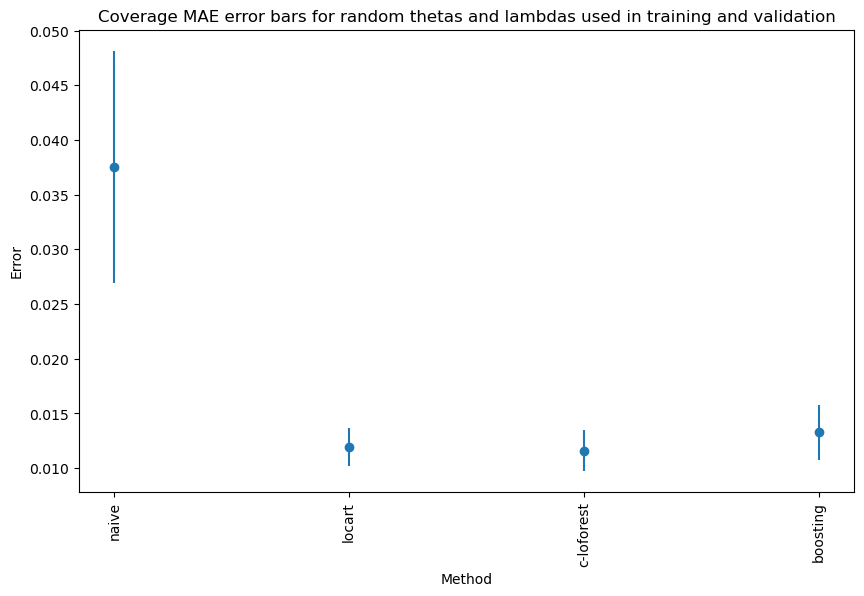

In [90]:
# Extract keys and values from the dictionary
keys = list(err_random_thetas_validation.keys())
values = list(err_random_thetas_validation.values())

# Separate mean absolute errors and standard errors
mae = [val[0] for val in values]
std_err = [val[1] for val in values]

# Create an error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(keys, mae, yerr=std_err, fmt='o')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title('Coverage MAE error bars for random thetas and lambdas used in training and validation')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

# Assessing coverage for several training sample sizes:

Implementing function to return coverage data

In [103]:
def calculate_coverage(sample_sizes, random_seed = 45, step = 0.1, alpha = 0.05):
    mean_list = []
    se_list = []
    names_list = []
    size_lists = []
    theta_grid_eval = np.arange(0.1, 7, step)

    for size in tqdm(sample_sizes, desc="Processing sample sizes"):
        # Generate parameters
        random_theta_grid, lambdas, data_melted = generate_parameters_random(n = size, random_seed = random_seed)

        # Model thetas for locart, loforest and boosting
        model_thetas = random_theta_grid.reshape(-1, 1)
        model_lambdas = np.array(lambdas)

        # Naive quantiles
        naive_quantiles = train_naive_quantile_random(n_random = size, alpha = alpha)
        naive = predict_naive_quantile(theta_grid_eval, naive_quantiles)
        coverage_list = eval_coverage(naive, theta_grid_eval, iters = 1000, verbose = False)
        mean_mae, std_error = coverage_list[0], coverage_list[1]
        mean_list.append(mean_mae)
        se_list.append(std_error)
        names_list.append("naive")
        size_lists.append(size)


        # Locart quantiles
        locart_object = LocartSplit(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
        locart_quantiles = locart_object.calib(model_thetas, model_lambdas, min_samples_leaf = 300)
        idxs = locart_object.cart.apply(theta_grid_eval.reshape(-1, 1))
        list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]
        coverage_list = eval_coverage(list_locart_quantiles, theta_grid_eval, iters = 1000, verbose = False)
        mean_mae, std_error = coverage_list[0], coverage_list[1]
        mean_list.append(mean_mae)
        se_list.append(std_error)
        names_list.append("locart")
        size_lists.append(size)


        # Loforest quantiles
        loforest_object = ConformalLoforest(LambdaScore, None, alpha = 0.05, is_fitted = True, split_calib = False)
        loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 300)
        loforest_cutoffs = loforest_object.compute_cutoffs(theta_grid_eval.reshape(-1, 1))
        coverage_list = eval_coverage(loforest_cutoffs, theta_grid_eval, iters = 1000, verbose = False)
        mean_mae, std_error = coverage_list[0], coverage_list[1]
        mean_list.append(mean_mae)
        se_list.append(std_error)
        names_list.append("loforest")
        size_lists.append(size)


        # Boosting quantiles
        model = HistGradientBoostingRegressor(loss="quantile", quantile=.95, random_state = 105)
        model.fit(model_thetas, model_lambdas)
        boosting_quantiles = model.predict(theta_grid_eval.reshape(-1, 1))
        eval_coverage(boosting_quantiles, theta_grid_eval, iters = 1000, verbose = False)
        coverage_list = eval_coverage(boosting_quantiles, theta_grid_eval, iters = 1000, verbose = False)
        mean_mae, std_error = coverage_list[0], coverage_list[1]
        mean_list.append(mean_mae)
        se_list.append(std_error)
        names_list.append("boosting")
        size_lists.append(size)
    
    coverage_data = pd.DataFrame({
        "coverage_mae": mean_list,
        "std_error": se_list,
        "method": names_list,
        "n": size_lists
    })

    return coverage_data

In [95]:
np.arange(0.1, 7, 6.9/2)

array([0.1 , 3.55])

In [104]:
coverage_data = calculate_coverage(np.array([1000, 2500, 5000, 10000, 12500, 15000, 20000, 30000, 50000, 75000, 100000]))

Processing sample sizes: 100%|██████████| 11/11 [47:15<00:00, 257.80s/it]


/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> ma

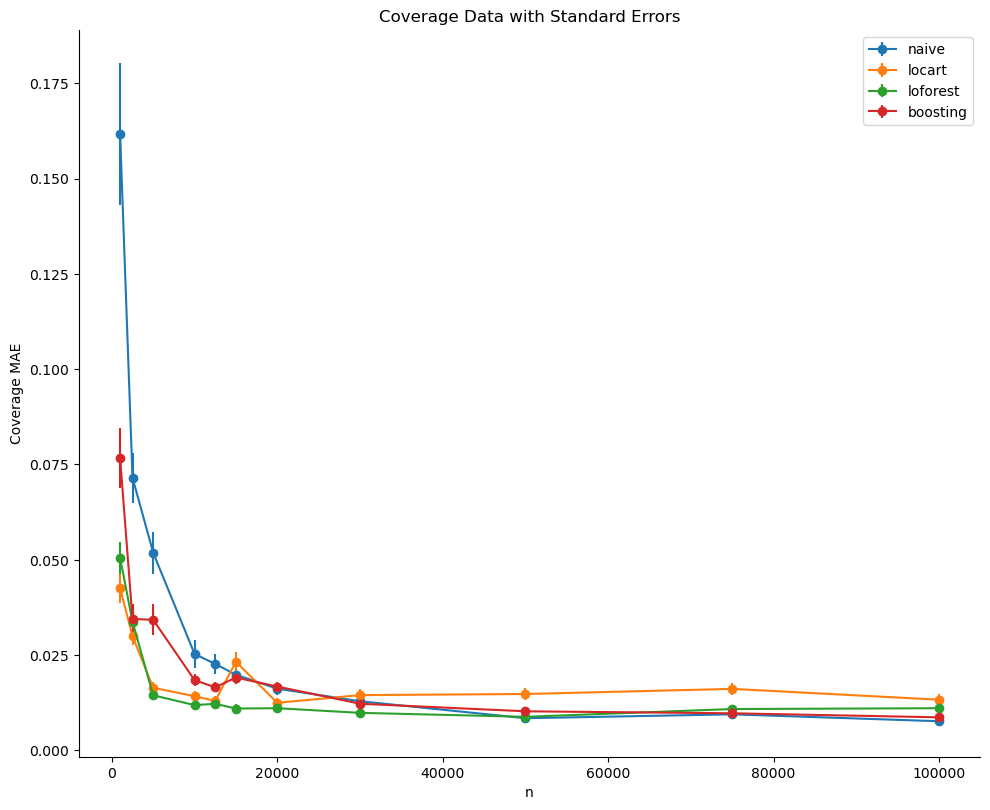

In [105]:
# Create a line plot with error bars
g = sns.FacetGrid(coverage_data, height = 8, aspect = 1.25, hue = "method")
g.map(plt.errorbar, "n", "coverage_mae", "std_error", marker = 'o', fmt = "-o")

# Set plot title and labels
plt.plot()
plt.legend()
plt.title('Coverage Data with Standard Errors')
plt.xlabel('n')
plt.ylabel('Coverage MAE')

# Show the plot
plt.show()